In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
#API
import requests

url = "https://alpha-vantage.p.rapidapi.com/query"

querystring = {"function":"TIME_SERIES_DAILY_ADJUSTED","symbol":"SPY","outputsize":"full","datatype":"json"}

headers = {
    'x-rapidapi-host': "alpha-vantage.p.rapidapi.com",
    'x-rapidapi-key': "7685be81fbmshe1096440c44d93ap1d4491jsn8ba57bf52657"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

data = json.loads(response.text)

In [3]:
#file for embedding
f = open("GloVe\\glove.6B.50d.txt", 'r', encoding='utf8')
M=50
emmbed_dict = {}
for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector

In [4]:
data_ya = pd.read_csv('yahoo_finance_marked_df.csv')

In [5]:
#function for df
def marked_news(ya): 
    marked = pd.DataFrame({'mark1': np.zeros(ya.shape[0]),
                           'mark2': np.zeros(ya.shape[0]),
                           'date': np.zeros(ya.shape[0]),
                        'new': np.zeros(ya.shape[0]),
                          'volume': np.zeros(ya.shape[0]),
                          })
    for i in range(M):
        marked[i] = np.zeros(ya.shape[0])

    i=0
    for new in ya['news']:
        marked.loc[i, 'new']=new
        marked.loc[i, 'date']=ya.loc[i, 'date']
        i+=1
    return marked

In [6]:
#create df
df = marked_news(data_ya)

In [7]:
df

,mark1,mark2,date,new,volume,0,1,2,3,4,...,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,2021-10-01,"TAIPEI, Oct 1 (Reuters) - Resolving the global...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,2021-10-01,(Bloomberg) -- Asian stocks and U.S. futures s...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2021-10-01,"TOKYO, Oct 1 (Reuters) - Japanese shares tumbl...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,2021-10-01,By Sonali PaulMELBOURNE (Reuters) - Oil prices...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,2021-10-01,By Kevin BucklandTOKYO (Reuters) - Asian equit...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,0.0,0.0,2021-09-17,"Anastasia Amoroso, iCapital Network Chief Inve...",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1378,0.0,0.0,2021-09-15,The Bank of England expects inflation to hit 4...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1379,0.0,0.0,2021-09-14,The major Asia-Pacific stock indexes traded mi...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1380,0.0,0.0,2021-09-14,(Bloomberg) -- Japanese stocks advanced for a ...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def volumer(df):
    for key in data['Time Series (Daily)'].keys():
        df.loc[df['date']==key, 'volume']=data['Time Series (Daily)'][key]['6. volume']
        
def find_big_VOLUME(df, mas):
    for date in mas:
        df.loc[df['date']==date, 'mark2']=1
        
def find_VOLUME(data):
    keys = list(data['Time Series (Daily)'].keys())
    mas = []
    n=10
    for i in range(len(keys)-n):
        sum=0
        for j in range(n):
            sum+=int(data['Time Series (Daily)'][keys[i+j]]['6. volume'])
        sum/=n
        if(int(data['Time Series (Daily)'][keys[i+n]]['6. volume'])>(1.5)*sum):
            mas.append(keys[i+n])
    return mas

def to_vectors(df):
    i=0
    words=[]
    for new in df['new']:
        vectors = []
        words.append([])
        for word in new.split(' '):
            if(word not in stopwords.words('english')):
                try:
                    vectors.append(emmbed_dict[word])
                    words[i].append(word)
                except:
                    continue
        final_vec = [0]*M
        for j in range(len(vectors)):
            final_vec+=vectors[j]
        final_vec/=len(vectors)
        for j in range(M):
            df.loc[i, j] = final_vec[j]
        i+=1
    return words

def get_vectors(df):
    returner = []
    for line in range (df.shape[0]):
        vector = []
        for i in range(M):
            vector.append(df.loc[line, i])
        returner.append(vector)
    return returner


In [9]:
#apply volume to df
volumer(df)

In [10]:
#find days with big volume
mas = find_VOLUME(data)

In [11]:
#mark news 
find_big_VOLUME(df, mas)

In [13]:
#GloVe
words = to_vectors(df)

In [14]:
#get vectors from df
vectors = get_vectors(df)

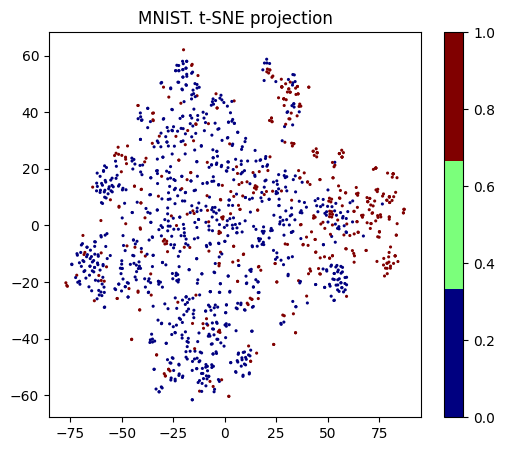

In [15]:
#TSNE for news with out tfidf
from sklearn.manifold import TSNE
tsne = TSNE(random_state=17, init='pca')
X = vectors
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['mark2'],
            edgecolor='none', alpha=1, s=5,
            cmap=plt.cm.get_cmap('jet', 3))
plt.colorbar()
plt.title('MNIST. t-SNE projection')
plt.show()

In [19]:
#create tfidf data frame
tfidf=[]
for new in np.array(df['new']):
    tfidf.append(new)
vectorizer = TfidfVectorizer()
weights = vectorizer.fit_transform(tfidf)
tfidf_pd = pd.DataFrame(weights.toarray(), columns=vectorizer.get_feature_names())

In [20]:
#create df with tfidf
df_1 = df.copy()
i=0
for new in df['new']:
    vectors_1 = []
    for word in new.split(' '):
        try:
            vectors_1.append(emmbed_dict[word]*tfidf_pd[i, word])
        except:
            try:
                vectors_1.append(emmbed_dict[word])
            except:
                continue
    final_vec = [0]*M
    for j in range(len(vectors_1)):
        final_vec+=vectors_1[j]
    final_vec/=len(vectors_1)
    for j in range(M):
        df_1.loc[i, j] = final_vec[j]
    i+=1

In [23]:
vectors_1 = get_vectors(df_1)

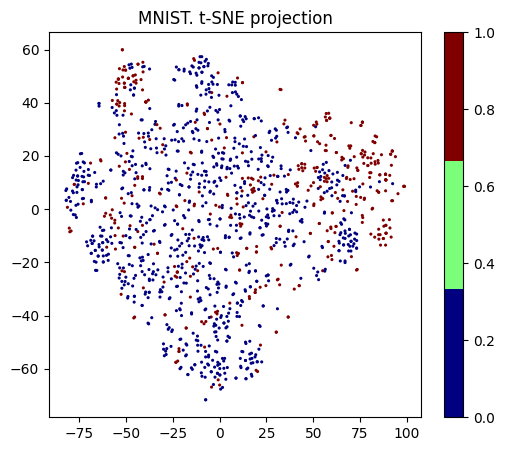

In [25]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=17, init='pca')
X = vectors_1
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['mark2'],
            edgecolor='none', alpha=1, s=5,
            cmap=plt.cm.get_cmap('jet', 3))
plt.colorbar()
plt.title('MNIST. t-SNE projection')
plt.show()

In [29]:
#clustering
n=3
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = n)
X=vectors_1
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [30]:
np.unique(y_kmeans)

array([0, 1, 2])

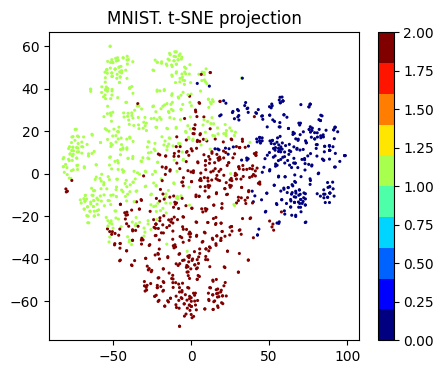

In [31]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=17, init='pca')
X = vectors_1
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(5,4))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_kmeans,
            edgecolor='none', alpha=1, s=5,
            cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection')
plt.show()

In [32]:
#class representation
a=y_kmeans
Final = pd.DataFrame({
    'count': np.zeros(n+1),
    '1':np.zeros(n+1),
    '0':np.zeros(n+1)
})

for i in range(len(a)):
    Final.iloc[a[i]]['count']+=1
    if(df['mark2'][i]==0):
        Final.iloc[a[i]]['0']+=1
    if(df['mark2'][i]==1):
        Final.iloc[a[i]]['1']+=1

In [33]:
Final

,count,1,0
0,316.0,207.0,109.0
1,534.0,130.0,404.0
2,532.0,117.0,415.0
3,0.0,0.0,0.0
